In [1]:
import os
from langchain_openai import AzureOpenAIEmbeddings
from dotenv import load_dotenv

load_dotenv()
embeddings = AzureOpenAIEmbeddings(
openai_api_type="azure",
openai_api_version=os.environ["OPENAI_API_EMBEDDING_VERSION"],
openai_api_key=os.environ["OPENAI_API_EMBEDDING_KEY"],
azure_endpoint=os.environ["AZURE_OPENAI_EMBEDDING_ENDPOINT"],
deployment=os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT"],
model=os.environ["AZURE_OPENAI_EMBEDDING_MODEL"],
validate_base_url=True,
)

In [2]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone

pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))
vector_store = PineconeVectorStore(index=pc.Index("langstuffindex"), embedding=embeddings)

d:\agentagent\AgentAgent\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import logging
# Set up the logger
logging.basicConfig(
    level=logging.INFO,  # Set to DEBUG for detailed logs
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        # logging.FileHandler("scraper.log"),  # Log to a file
        logging.StreamHandler()  # Log to console
    ]
)

logger = logging.getLogger(__name__)

In [35]:
from bs4 import BeautifulSoup
import html2text
import httpx
from markdownify import markdownify


def fetch_documents(url: str) -> str:
    """Fetch a document from a URL and return the markdownified text.

    Args:
        url (str): The URL of the document to fetch.

    Returns:
        str: The markdownified text of the document.
    """
    httpx_client = httpx.Client(follow_redirects=True, timeout=10)

    try:
        response = httpx_client.get(url, timeout=10)
        response.raise_for_status()
        html_content = response
        soup = BeautifulSoup(html_content, 'html.parser')
        a_tags = soup.find_all('a')
        for a_tag in a_tags:
            a_tag.decompose()
        
        img_tags = soup.find_all('img')
        for img_tag in img_tags:
            img_tag.decompose()

        target_div = soup.find('div', class_= "theme-doc-markdown markdown") #langchain
        
        if not target_div:
            target_div = soup.find('article') #langraph
        
        if not target_div:
            return
        
        return html2text.html2text(str(target_div))
    except (httpx.HTTPStatusError, httpx.RequestError) as e:
        return f"Encountered an HTTP error: {str(e)}"

In [36]:
from pprint import pprint
pprint(fetch_documents("https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams"))

2025-04-08 20:33:46,190 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams "HTTP/1.1 301 Moved Permanently"
2025-04-08 20:33:46,206 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/ "HTTP/1.1 200 OK"


('# Hierarchical Agent Teams\n'
 '\n'
 'In our previous example (), we introduced the concept of a single to route\n'
 'work between different worker nodes.\n'
 '\n'
 'But what if the job for a single worker becomes too complex? What if the\n'
 'number of workers becomes too large?\n'
 '\n'
 'For some applications, the system may be more effective if work is '
 'distributed\n'
 '_hierarchically_.\n'
 '\n'
 'You can do this by composing different subgraphs and creating a top-level\n'
 'supervisor, along with mid-level supervisors.\n'
 '\n'
 "To do this, let's build a simple research assistant! The graph will look\n"
 'something like the following:\n'
 '\n'
 'This notebook is inspired by the paper , by Wu, et. al. In the rest of this\n'
 'notebook, you will:\n'
 '\n'
 "  1. Define the agents' tools to access the web and write files\n"
 '  2. Define some utilities to help create the graph and agents\n'
 '  3. Create and define each team (web research + doc writing)\n'
 '  4. Compose every

In [37]:
# list of agent architectures
agent_architecture_urls = ["https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration",
 "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor",
 "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams",
 "https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute",
 "https://langchain-ai.github.io/langgraph/tutorials/rewoo/rewoo",
 "https://langchain-ai.github.io/langgraph/tutorials/llm-compiler/LLMCompiler",
 "https://langchain-ai.github.io/langgraph/tutorials/reflection/reflection",
 "https://langchain-ai.github.io/langgraph/tutorials/reflexion/reflexion",
 "https://langchain-ai.github.io/langgraph/tutorials/lats/lats",
 "https://langchain-ai.github.io/langgraph/tutorials/self-discover/self-discover",
 "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams",
 "https://langchain-ai.github.io/langgraph/concepts/agentic_concepts",
 "https://langchain-ai.github.io/langgraph/concepts/multi_agent"
]

In [45]:
# TODO first subagent to create from https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/

# TODO critical thinking to allow for model suggestions

from pydantic import Field, BaseModel
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from typing import List
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import PromptTemplate
from langchain.tools.retriever import create_retriever_tool
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_openai import ChatOpenAI
from pprint import pprint
from models.agent_architecture import AgentArchitecture
from utils.yaml_builder import convert_to_yaml
from langgraph_gen.generate import generate_from_spec
from datetime import datetime
from langgraph.types import Send
import operator
from typing import Annotated

template = """Your job is to get information from a user about what kind of agent they wish to build.

You should get the following information from them:

- What the objective of the agent is
- Various responsibilities of the agent 
- What model provider to use

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the tool AgentInstruction """

class AgentInstructions(BaseModel):
    """Instructions on how to build the Agent"""
    objective: str = Field(description= "What is the primary objective of the agent")
    responsibilities: List[str] = Field(description= "What are the various responsibilities of the agent which it needs to fulfill")
    model_provider : str = Field(description= "Which model provider powers the LLM workload? eg. OpenAI/Claude/CodeLLama etc.")


class ArchEvaluationReport(BaseModel):
    """Class to represent the architecture evaluation report"""
    name: str = Field(description="Name of the agent architecture being evaluated")
    highlights: str = Field(description="Concise summary of the architecture in 5 lines")
    evaluation_score: int = Field(description="evaluation of suitability of the agentic_architecture against user requirements from 1-10, 1 being least relevant to 10 being most relevant")
    justification: str = Field(description="Justification for the score")
    tailored_design: str = Field(description="Tailored design using the architecture")


class AgentBuilderState(MessagesState):
    agent_instructions: AgentInstructions = Field("the requirement analysis generated by the model.")
    arch_evaluation_reports: Annotated[List[ArchEvaluationReport], operator.add] = Field("list of agent architectures suggested in map-reduce step")
    best_agent_architecture: ArchEvaluationReport = Field("The agent architecture best suited to above requirements")

class ArchitectureEvaluationState(MessagesState):
    agent_instructions: AgentInstructions = Field("the requirement analysis generated by the model.")
    url: str = Field("url of the agent architecture to evaluate against")

llm = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

def requirement_analysis_node(state: AgentBuilderState):
    
    llm_with_tool = llm.bind_tools([AgentInstructions])
    response = llm_with_tool.invoke([SystemMessage(content=template)] + state["messages"])
    
      # Construct the final answer from the arguments of the last tool call  
    if len(response.tool_calls) == 0:
        return {"messages": [response]}
    
    agent_instructions = response.tool_calls[0]
    agent_instructions = AgentInstructions(**agent_instructions["args"])
    
    return {"messages": [response], "agent_instructions": agent_instructions}

ARCH_EVALUATION_PROMPT = PromptTemplate.from_template(
    """
You are tasked with assessing the provided agentic architecture documentation to determine its relevance and applicability to the user requirements outlined below.

Agentic Architecture Documentation:

{agent_architecture}

User Requirements:

Objectives: {objective}

Responsibilities: {responsibilities}

Deliverables: 

Provide your evaluation in the following structured format:

1. Name of the Agent Architecture

2. A concise name for the architecture being evaluated.

3. 2-3 Line Highlights about the Architecture

4. Summarize the key features and unique aspects of the architecture.

5. Relevance Score (1-10) : Provide a numerical score (1 being not relevant, 10 being highly relevant) based on the alignment between the architecture and the user requirements.

6. Justification for the Score: A brief rationale (5-10 lines) explaining why you gave this score, citing specific features or misalignments with the user requirements.

7. Tailored Design Using the Architecture for the User Requirements: Propose an implementation of the architecture that aligns with the user’s objectives and responsibilities. Be precise and action-focused in detailing how it can meet their needs.
"""
)

def architecture_evaluation_map_node(state: AgentBuilderState):
    return [Send("evaluate_against_architecture", {"agent_instructions": state["agent_instructions"], "url": url}) for url in agent_architecture_urls]

def route_state(state: AgentBuilderState):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "requirement_analysis"

def evaluate_against_architecture(state: ArchitectureEvaluationState):
    agent_instructions: AgentInstructions = state["agent_instructions"]
    url: str = state["url"]
    llm_with_structured_output = llm.with_structured_output(ArchEvaluationReport)
    archEvaluationReport: ArchEvaluationReport = llm_with_structured_output.invoke(
        [SystemMessage(content=ARCH_EVALUATION_PROMPT.format(agent_architecture=fetch_documents(url),
                                                             objective=agent_instructions.objective,
                                                             responsibilities=agent_instructions.responsibilities))])
    
    return {
        "messages": [AIMessage(content=f"Evaluated architecture {url}, arch_name: {archEvaluationReport.name}")],
        "arch_evaluation_reports": [archEvaluationReport],
    }

def best_architecture(state: AgentBuilderState):
    """Select the best architecture based on the evaluation reports."""
    # Sort the architectures based on their evaluation scores
    sorted_architectures = sorted(state["arch_evaluation_reports"], key=lambda x: x.evaluation_score, reverse=True)
    
    # Select the best architecture (the first one in the sorted list)
    best_architecture = sorted_architectures[0]
    
    print("found the best architecture")
    pprint(best_architecture.json())
    
    # Return the best architecture as the output
    return {
        "messages": [AIMessage(content="Best architecture selected!")],
        "best_agent_architecture": best_architecture,
    }

memory = MemorySaver()
workflow = StateGraph(AgentBuilderState)
workflow.add_node("requirement_analysis", requirement_analysis_node)
workflow.add_node("evaluate_against_architecture", evaluate_against_architecture)
workflow.add_node("best_architecture", best_architecture)
@workflow.add_node
def add_tool_message(state: AgentBuilderState):
    
   
    return {
        "messages": [
            ToolMessage(
                content="Requirements generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }



workflow.add_edge("best_architecture", END)
workflow.add_edge("evaluate_against_architecture", "best_architecture")
workflow.add_conditional_edges("add_tool_message", architecture_evaluation_map_node,["evaluate_against_architecture"])
workflow.add_conditional_edges("requirement_analysis", route_state, ["add_tool_message", "requirement_analysis", END])
workflow.add_edge(START, "requirement_analysis")
infograph = workflow.compile(checkpointer=memory)

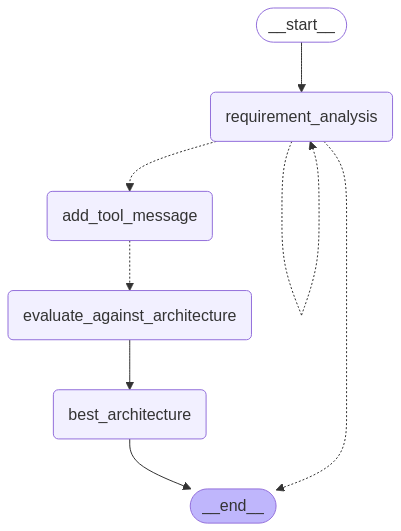

In [43]:
from IPython.display import Image, display
display(Image(infograph.get_graph().draw_mermaid_png()))


In [16]:
# I wish to build a nutritional LLM agent which tracks user goals, allows logging via natural language, provide nutritional and exercise guidance

# 1. lose weight, gain muscle. 2. suggest recipes, provide guidance, track meals, allow meal logging. 3. OpenAi

In [46]:
import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in infograph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")
        

User (q/Q to quit):  I wish to build a nutritional LLM agent which tracks user goals, allows logging via natural language, provide nutritional and exercise guidance


2025-04-08 20:50:47,622 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Great! Let's gather some more specific information to help build your nutritional LLM agent.

1. **Objective**: You've mentioned that the agent will track user goals and provide guidance. Can you clarify the primary objective of the agent? For example, is it to help users lose weight, gain muscle, maintain a healthy lifestyle, or something else?

2. **Responsibilities**: You mentioned logging via natural language and providing guidance. Could you list out the specific responsibilities you want the agent to fulfill? For example, tracking meals, suggesting recipes, providing workout plans, etc.

3. **Model Provider**: Do you have a specific model provider in mind for powering the LLM workload? For example, OpenAI, Claude, CodeLLama, etc.

Once I have this information, I can proceed to create the agent instructions for you!
User (q/Q to quit): 1. lose weight, gain muscle. 2. suggest recipes, provide guidance

2025-04-08 20:50:53,468 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  AgentInstructions (call_KXroLtcfJSBW4IvXfji0iK5p)
 Call ID: call_KXroLtcfJSBW4IvXfji0iK5p
  Args:
    objective: lose weight, gain muscle
    responsibilities: ['suggest recipes', 'provide guidance', 'track meals', 'allow meal logging']
    model_provider: OpenAI
================================= Tool Message =================================

Requirements generated!


2025-04-08 20:50:57,915 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams "HTTP/1.1 301 Moved Permanently"
2025-04-08 20:50:57,920 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams "HTTP/1.1 301 Moved Permanently"
2025-04-08 20:50:57,946 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/ "HTTP/1.1 200 OK"
2025-04-08 20:50:57,953 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/ "HTTP/1.1 200 OK"
2025-04-08 20:50:57,998 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor "HTTP/1.1 301 Moved Permanently"
2025-04-08 20:50:58,100 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/ "HTTP/1.1 200 OK"
2025-04-08 20:50:58,184 - 

================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/self-discover/self-discover, arch_name: Self-Discover Agent
================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor, arch_name: Multi-agent Supervisor Architecture
================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams, arch_name: Hierarchical Agent Teams
================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams, arch_name: Hierarchical Agent Teams


2025-04-08 20:51:06,107 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/concepts/agentic_concepts, arch_name: Tool Calling Agent Architecture


2025-04-08 20:51:07,804 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/concepts/multi_agent "HTTP/1.1 301 Moved Permanently"
2025-04-08 20:51:07,820 - INFO - HTTP Request: GET https://langchain-ai.github.io/langgraph/concepts/multi_agent/ "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/rewoo/rewoo, arch_name: ReWOO
================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/reflection/reflection, arch_name: LangGraph
================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration, arch_name: Multi-agent network
================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/reflexion/reflexion, arch_name: Reflexion
================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/llm-compiler/LLMCompiler, arch_nam

2025-04-08 20:51:09,044 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute, arch_name: Plan-and-Execute Agent Architecture
================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/tutorials/lats/lats, arch_name: Language Agent Tree Search (LATS)
================================== Ai Message ==================================

Evaluated architecture https://langchain-ai.github.io/langgraph/concepts/multi_agent, arch_name: Multi-agent Systems
found the best architecture
('{"name":"Tool Calling Agent Architecture","highlights":"The Tool Calling '
 'Agent Architecture enables LLMs to make multi-step decisions and utilize '
 'various tools to accomplish tasks. It incorporates memory for retaining '
 'information across interactions and planning capabilities for dynamic '
 'problem-solving. 

# Successful langsmith trace!!!!!
https://smith.langchain.com/o/468caf91-70e3-4345-8663-a31e215a7073/projects/p/c25726df-41a9-47c0-abcd-dac2cb93f480?timeModel=%7B%22duration%22%3A%227d%22%7D&runtab=0&peek=6c9b8b6f-bd3c-4436-8997-af1059c4ca65